In [64]:
# Block 2: Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib


In [65]:
# Block 3: Load dataset
def load_data():
    data = pd.read_csv("data.csv", encoding="ISO-8859-1")  # Specify encoding to handle special characters
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    return data

# Load data
data = load_data()


In [66]:
# Block 4: Calculate RFM metrics
def calculate_rfm(data):
    reference_date = data['InvoiceDate'].max() + dt.timedelta(days=1)
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'Quantity': lambda x: (x * data.loc[x.index, 'UnitPrice']).sum()
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    rfm['Monetary'] = rfm['Monetary'].clip(lower=0)  # Handle negative values if any
    return rfm

# Calculate RFM
rfm = calculate_rfm(data)

# # Fit the MinMaxScaler and save it
# scaler = MinMaxScaler()
# scaler.fit(rfm[['Recency', 'Frequency', 'Monetary']])

# # Save the scaler
# joblib.dump(scaler, "scaler.joblib")

# Fit the scaler on the RFM training data
scaler = MinMaxScaler()
scaler.fit(rfm[['Recency', 'Frequency', 'Monetary']])

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

           Recency    Frequency      Monetary
count  4372.000000  4372.000000   4372.000000
mean     92.047118     5.075480   1401.669937
std     100.765435     9.338754   1977.681559
min       1.000000     1.000000      0.000000
25%      17.000000     1.000000    293.362500
50%      50.000000     3.000000    648.075000
75%     143.000000     5.000000   1611.725000
max     374.000000   248.000000  10000.000000
Cluster
0    2628
3     784
1     631
2     329
Name: count, dtype: int64

Silhouette Score: 0.5287

Mean of each feature for each cluster:
            Recency  Frequency     Monetary
Cluster                                    
0         33.695586   4.402207  1151.089548
1        295.621236   1.537242   364.610428
2         18.382979  23.483283  7236.047751
3        154.710459   2.455357   627.944823


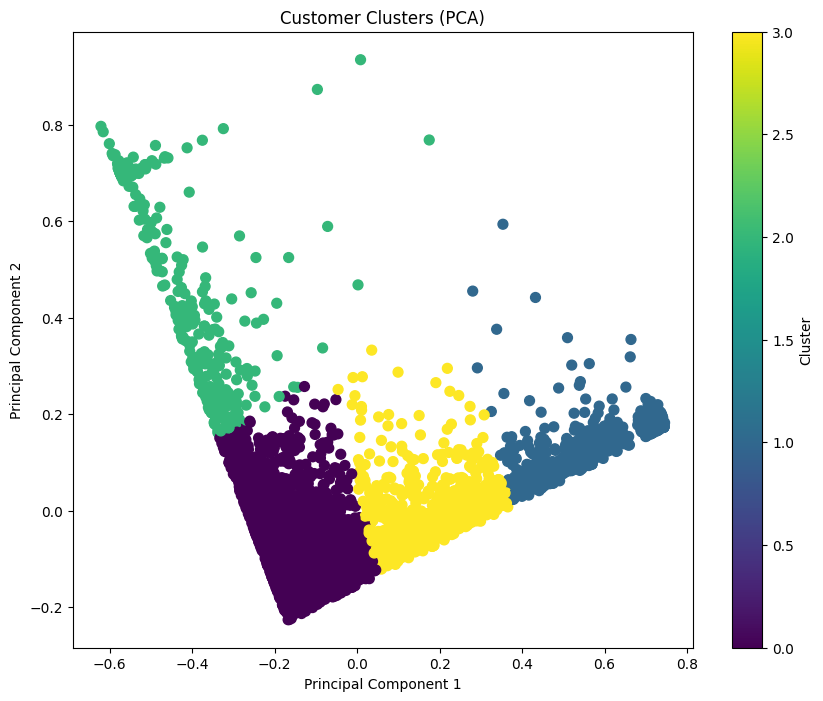

['kmeans_model.pkl']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib

# 2. Clip outliers in Recency, Frequency, and Monetary (optional, adjust upper limits as needed)
rfm[['Recency', 'Frequency', 'Monetary']] = rfm[['Recency', 'Frequency', 'Monetary']].clip(lower=0, upper=10000)

# 3. Scale the features
scaler = MinMaxScaler()
scaled_rfm = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 4. Apply KMeans clustering with KMeans++ initialization for better convergence
kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++')
kmeans.fit(scaled_rfm)

# 5. Label clusters and add cluster labels to the data
def label_clusters(rfm, kmeans):
    cluster_labels = kmeans.predict(scaled_rfm)
    rfm['Cluster'] = cluster_labels
    cluster_mapping = {
        0: "High Spender",
        1: "Lapsed Customer",
        2: "Frequent Buyer",
        3: "Occasional Buyer"
    }
    rfm['Segment'] = rfm['Cluster'].map(cluster_mapping)
    return rfm

rfm = label_clusters(rfm, kmeans)

# 6. Print summary statistics of the clusters
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())
print(rfm['Cluster'].value_counts())

# 7. Calculate the Silhouette Score
sil_score = silhouette_score(scaled_rfm, rfm['Cluster'])
print(f"\nSilhouette Score: {sil_score:.4f}")

# 8. Visualize the clusters using PCA to reduce the features to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_rfm)

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=rfm['Cluster'], cmap='viridis', s=50)

# Calculate the mean of each feature for each cluster
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Print the mean values for each cluster
print("\nMean of each feature for each cluster:")
print(cluster_means)

plt.title("Customer Clusters (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# 1. Split the data into train and test sets
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 3. Predict the labels on the test set
y_pred = log_reg.predict(X_test)

# 4. Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# 5. Assign predicted labels to the original dataset
rfm['Cluster_LogReg'] = log_reg.predict(X)
rfm['Segment_LogReg'] = rfm['Cluster_LogReg'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})

# 6. Print the mean of each feature for each cluster
cluster_means = rfm.groupby('Cluster_LogReg')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nMean of each feature for each cluster:")
print(cluster_means)

# 7. Save the model to a file
joblib.dump(log_reg, 'logistic_regression_model.pkl')


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       792
           1       1.00      1.00      1.00       184
           2       0.98      0.99      0.98        98
           3       0.99      0.99      0.99       238

    accuracy                           0.99      1312
   macro avg       0.99      0.99      0.99      1312
weighted avg       0.99      0.99      0.99      1312


Mean of each feature for each cluster:
                   Recency  Frequency     Monetary
Cluster_LogReg                                    
0                33.665398   4.393605  1149.420652
1               295.782540   1.547619   372.095127
2                18.501511  23.404834  7205.876918
3               155.005102   2.456633   623.734338


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logistic_regression_model.pkl']

In [69]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize and train the Random Forest Classifier model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# 2. Predict the labels on the test set
y_pred_rf = rf_clf.predict(X_test)

# 3. Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 4. Assign predicted labels to the original dataset
rfm['Cluster_RF'] = rf_clf.predict(X)
rfm['Segment_RF'] = rfm['Cluster_RF'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})

joblib.dump(rf_clf, 'random_forest_model.pkl')


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       792
           1       1.00      0.99      1.00       184
           2       0.98      0.98      0.98        98
           3       0.99      1.00      0.99       238

    accuracy                           0.99      1312
   macro avg       0.99      0.99      0.99      1312
weighted avg       0.99      0.99      0.99      1312



['random_forest_model.pkl']

In [70]:
from sklearn.svm import SVC

# 1. Initialize and train the Support Vector Machine model
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

# 2. Predict the labels on the test set
y_pred_svm = svm_clf.predict(X_test)

# 3. Print classification report
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))

# 4. Assign predicted labels to the original dataset
rfm['Cluster_SVM'] = svm_clf.predict(X)
rfm['Segment_SVM'] = rfm['Cluster_SVM'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})
joblib.dump(svm_clf, 'svm_model.pkl')

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       792
           1       1.00      1.00      1.00       184
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00       238

    accuracy                           1.00      1312
   macro avg       1.00      1.00      1.00      1312
weighted avg       1.00      1.00      1.00      1312



['svm_model.pkl']

In [71]:
from sklearn.tree import DecisionTreeClassifier

# 1. Initialize and train the Decision Tree Classifier model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# 2. Predict the labels on the test set
y_pred_dt = dt_clf.predict(X_test)

# 3. Print classification report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# 4. Assign predicted labels to the original dataset
rfm['Cluster_DT'] = dt_clf.predict(X)
rfm['Segment_DT'] = rfm['Cluster_DT'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})
joblib.dump(dt_clf, 'decision_tree_model.pkl')

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       792
           1       0.99      0.99      0.99       184
           2       0.98      0.96      0.97        98
           3       0.99      0.99      0.99       238

    accuracy                           0.99      1312
   macro avg       0.99      0.98      0.99      1312
weighted avg       0.99      0.99      0.99      1312



['decision_tree_model.pkl']

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

# 1. Initialize and train the Gradient Boosting Classifier model
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# 2. Predict the labels on the test set
y_pred_gb = gb_clf.predict(X_test)

# 3. Print classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# 4. Assign predicted labels to the original dataset
rfm['Cluster_GB'] = gb_clf.predict(X)
rfm['Segment_GB'] = rfm['Cluster_GB'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})
joblib.dump(gb_clf, 'gradient_boosting_model.pkl')

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       792
           1       1.00      0.99      1.00       184
           2       0.98      0.98      0.98        98
           3       0.99      0.99      0.99       238

    accuracy                           0.99      1312
   macro avg       0.99      0.99      0.99      1312
weighted avg       0.99      0.99      0.99      1312



['gradient_boosting_model.pkl']

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import joblib

# 1. Initialize and train the K-Nearest Neighbors model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# 2. Predict the labels on the test set
y_pred_knn = knn_clf.predict(X_test)

# 3. Print classification report
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# 4. Assign predicted labels to the original dataset
rfm['Cluster_KNN'] = knn_clf.predict(X)
rfm['Segment_KNN'] = rfm['Cluster_KNN'].map({
    0: "High Spender",
    1: "Lapsed Customer",
    2: "Frequent Buyer",
    3: "Occasional Buyer"
})

# 5. Save the trained model for future use
joblib.dump(knn_clf, 'knn_model.pkl')


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       792
           1       0.97      0.97      0.97       184
           2       0.98      0.98      0.98        98
           3       0.97      0.88      0.92       238

    accuracy                           0.97      1312
   macro avg       0.97      0.96      0.96      1312
weighted avg       0.97      0.97      0.97      1312



['knn_model.pkl']